In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Domik Dataset

In [3]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [4]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [5]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

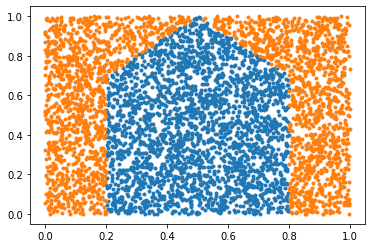

In [6]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=1)

# plotting
domik.show()

## Net

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 15)
        self.fc2 = nn.Linear(15, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.3705919463758652
Epoch        1 Loss: 0.20566729493897828
Epoch        2 Loss: 0.16916067612511657
Epoch        3 Loss: 0.15214799139013813
Epoch        4 Loss: 0.1400787773308319
Epoch        5 Loss: 0.13248145348143298
Epoch        6 Loss: 0.12720412151005758
Epoch        7 Loss: 0.12052014675947016
Epoch        8 Loss: 0.11780726496120655
Epoch        9 Loss: 0.11601282238035387
Epoch       10 Loss: 0.11183954549171095
Epoch       11 Loss: 0.10959213327605655
Epoch       12 Loss: 0.1091595717862121
Epoch       13 Loss: 0.1073670224804376
Epoch       14 Loss: 0.1057495106783102


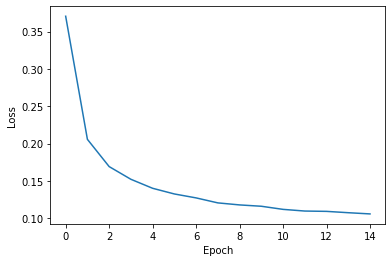

In [8]:
EPOCHS_TO_TRAIN = 15
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.BCELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.05878880443788055
Epoch        1 Loss: 0.05688869940791689
Epoch        2 Loss: 0.05623432995251071
Epoch        3 Loss: 0.0558211612415551
Epoch        4 Loss: 0.05554846178242064
Epoch        5 Loss: 0.05518427234666922
Epoch        6 Loss: 0.05490473374400849
Epoch        7 Loss: 0.05463740296527607
Epoch        8 Loss: 0.05438000609817361
Epoch        9 Loss: 0.054148252978893814
Epoch       10 Loss: 0.05389235391886803
Epoch       11 Loss: 0.05365918044994369
Epoch       12 Loss: 0.053434824113319436
Epoch       13 Loss: 0.053215884325617274
Epoch       14 Loss: 0.053020912204137884


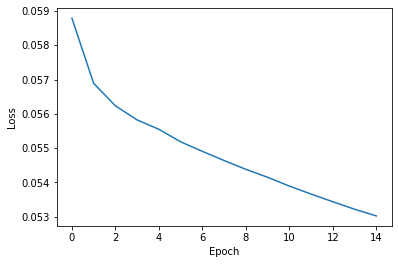

In [9]:
EPOCHS_TO_TRAIN = 15
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.BCELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

Accuracy of the network on the 25000 test samples: 98.656


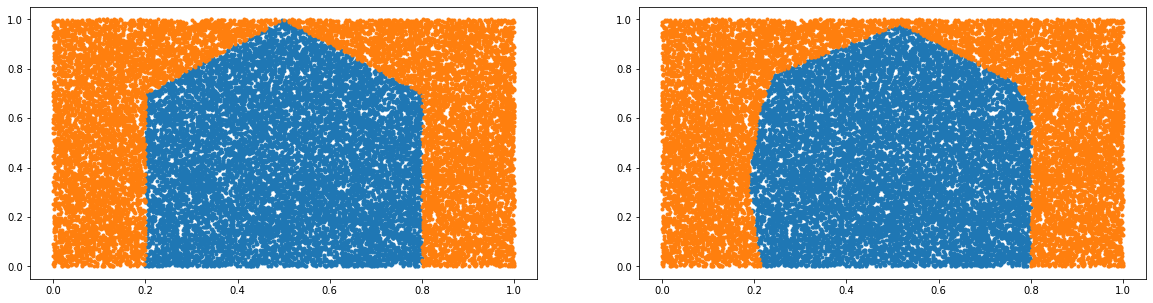

In [10]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik dataset for multi classes

In [11]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

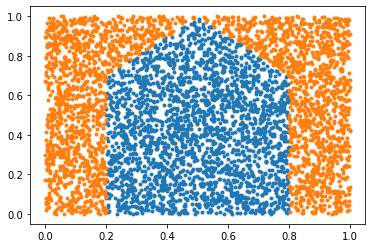

In [12]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

## Net

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)


## Train

Epoch        0 Loss: 0.6715894968086328
Epoch        1 Loss: 0.6186557223178987
Epoch        2 Loss: 0.4989920194698224
Epoch        3 Loss: 0.432626124496008
Epoch        4 Loss: 0.4097339764425121
Epoch        5 Loss: 0.3972559553924691
Epoch        6 Loss: 0.38855011969465086
Epoch        7 Loss: 0.38095762131452987
Epoch        8 Loss: 0.3746803014236935
Epoch        9 Loss: 0.37006422948822976
Epoch       10 Loss: 0.3665175177089883
Epoch       11 Loss: 0.3634588683016227
Epoch       12 Loss: 0.3610189331636217
Epoch       13 Loss: 0.35900157066112376
Epoch       14 Loss: 0.3572866429307179
Epoch       15 Loss: 0.35575965152361755
Epoch       16 Loss: 0.35443449583537007
Epoch       17 Loss: 0.3532712161004651
Epoch       18 Loss: 0.3522187634614248
Epoch       19 Loss: 0.35128872136763634
Epoch       20 Loss: 0.3504292524068314
Epoch       21 Loss: 0.3496470611003894
Epoch       22 Loss: 0.34892777859914353
Epoch       23 Loss: 0.3482509048920444
Epoch       24 Loss: 0.3476508604

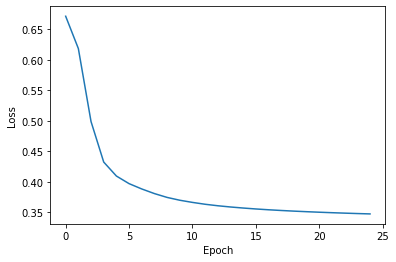

In [14]:
EPOCHS_TO_TRAIN = 25
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

## Test

In [15]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 98.336


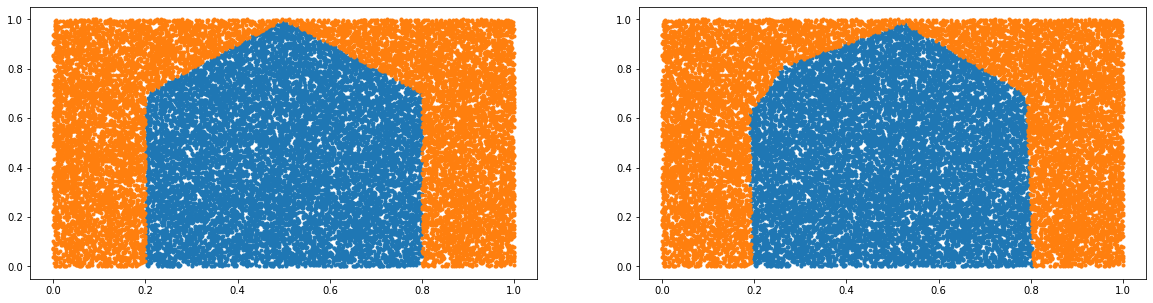

In [16]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik with window dataset

In [17]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

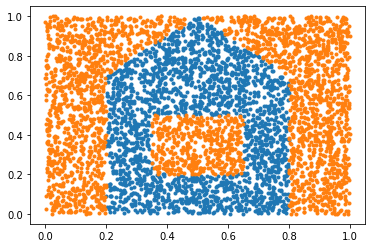

In [18]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)

# plotting
domik.show()

## Net

In [19]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.5339276843245676
Epoch        1 Loss: 0.43043079090346353
Epoch        2 Loss: 0.38792673265400973
Epoch        3 Loss: 0.3209850644841544
Epoch        4 Loss: 0.2661229481472941
Epoch        5 Loss: 0.2391191177978576
Epoch        6 Loss: 0.2224596443662672
Epoch        7 Loss: 0.21656925260645493
Epoch        8 Loss: 0.20991452170508915
Epoch        9 Loss: 0.20369526087539874


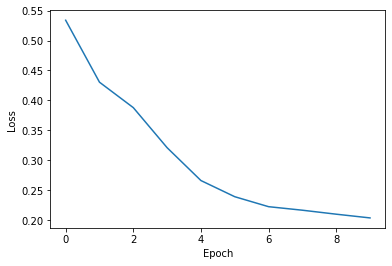

In [20]:
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.BCELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.09134977849605859
Epoch        1 Loss: 0.07159524492290217
Epoch        2 Loss: 0.06706158666583699
Epoch        3 Loss: 0.06464979961464745
Epoch        4 Loss: 0.06278088573927608
Epoch        5 Loss: 0.061372747558308745
Epoch        6 Loss: 0.060333300337292374
Epoch        7 Loss: 0.059360716428797526
Epoch        8 Loss: 0.058671931028644826
Epoch        9 Loss: 0.05806582456090964


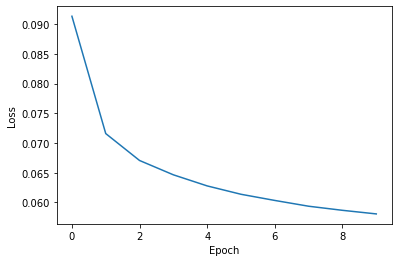

In [21]:
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.BCELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

Accuracy of the network on the 25000 test samples: 98.084


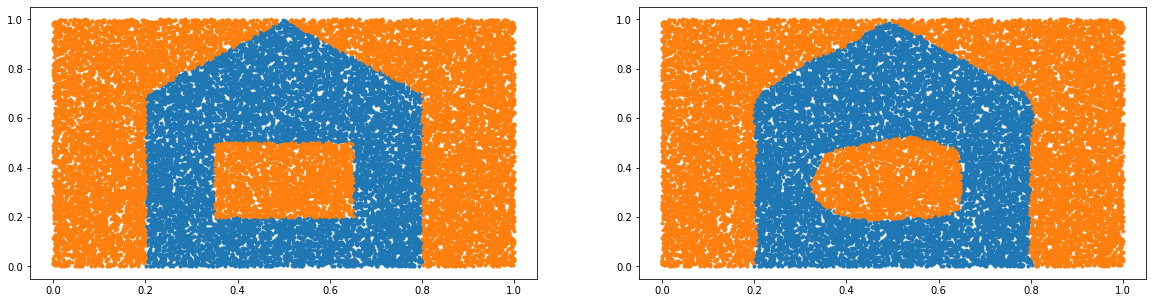

In [22]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Homework

- [X] Обучить обычный домик (Accuracy >98%). 1 балл
- [X] Использовать для этого двухслойную сеть. 1 балл
- [X] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [X] Использовать для этого двухслойную сеть. 1 балл
- [X] Обучить домик с окошком (Accuracy >98%). 1 балл
- [X] Использовать для этого трехслойную сеть. 1 балл
- [X] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [X] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

## Domik with door and 2 windows dataset

In [23]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0.], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0.], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2.], device=device)
            targets[i] = targets[i].long()
        return points, targets

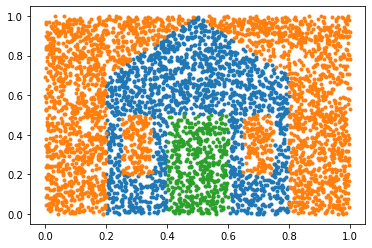

In [24]:
DATASET_SIZE = 5000
domik = DoorDomikDataset(DATASET_SIZE)

# plotting
domik.show()

## Net

In [25]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        #x = torch.softmax(self.fc3(x), dim=0)
        return torch.unsqueeze(x, 0)

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


## Train

Epoch        0 Loss: 0.6981501297022589
Epoch        1 Loss: 0.5114748180258429
Epoch        2 Loss: 0.41755504457035075
Epoch        3 Loss: 0.3699327255110357
Epoch        4 Loss: 0.34913852857758004
Epoch        5 Loss: 0.3283731697833854
Epoch        6 Loss: 0.32363291527428084
Epoch        7 Loss: 0.3031361686165549
Epoch        8 Loss: 0.3020528765974712
Epoch        9 Loss: 0.30051510179863566


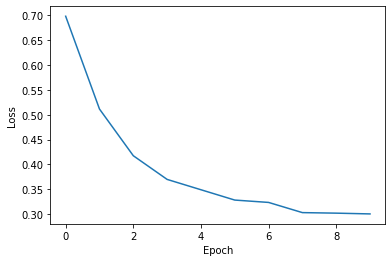

In [26]:
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(weight=torch.tensor([1.0, 5.0, 10.0])), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.12207231180675865
Epoch        1 Loss: 0.0854438242513878
Epoch        2 Loss: 0.07549741392434482
Epoch        3 Loss: 0.07029058265708236
Epoch        4 Loss: 0.06754604853804999
Epoch        5 Loss: 0.06556857356644664
Epoch        6 Loss: 0.06422949779865432
Epoch        7 Loss: 0.06323912782023697
Epoch        8 Loss: 0.062166445534737554
Epoch        9 Loss: 0.06309409646768652
Epoch       10 Loss: 0.061557747300797744
Epoch       11 Loss: 0.060625230920952525
Epoch       12 Loss: 0.0635635822230052
Epoch       13 Loss: 0.0608043085558779
Epoch       14 Loss: 0.06276341946478031
Epoch       15 Loss: 0.06052661752659579
Epoch       16 Loss: 0.060833331423842354
Epoch       17 Loss: 0.06408076798932827
Epoch       18 Loss: 0.060272962846144695
Epoch       19 Loss: 0.06058197010682984


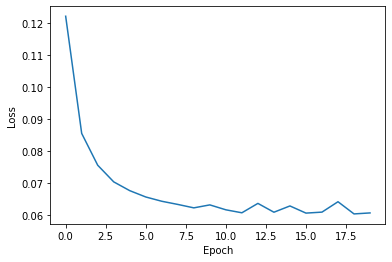

In [27]:
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(weight=torch.tensor([1.0, 5.0, 10.0])), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

Epoch        0 Loss: 0.040333849475465436
Epoch        1 Loss: 0.03653374647502036
Epoch        2 Loss: 0.0358293443987187
Epoch        3 Loss: 0.035133361952410326
Epoch        4 Loss: 0.034552747859084854
Epoch        5 Loss: 0.03424835969415319
Epoch        6 Loss: 0.03402961069518159
Epoch        7 Loss: 0.03381084868070797
Epoch        8 Loss: 0.03361919565817234
Epoch        9 Loss: 0.03326756757250695


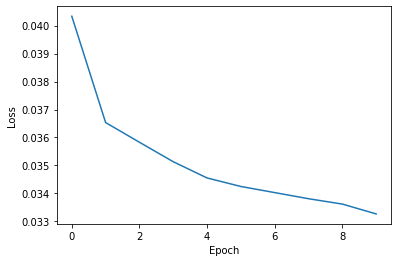

In [28]:
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(weight=torch.tensor([1.0, 5.0, 10.0])), 
      optimizer=optim.SGD(net.parameters(), lr=0.001))

## Test

In [29]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = torch.argmax(network(inp))
            total += 1
            correct += (output == target).sum().item()
            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 98.364


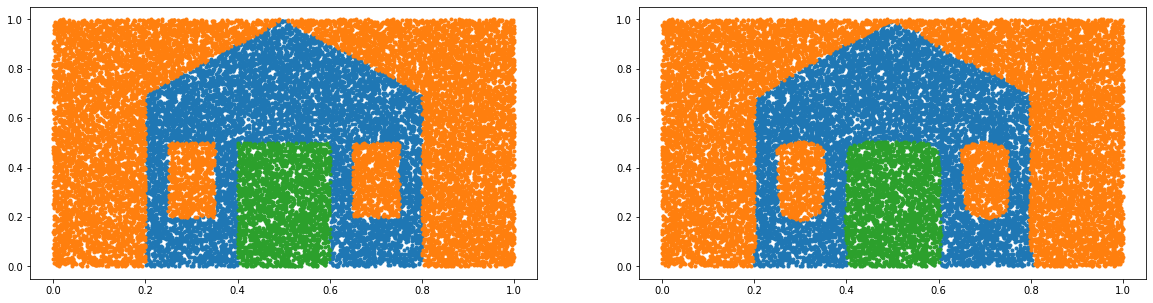

In [30]:
test_dataset = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net, test_dataset=test_dataset)